<a href="https://colab.research.google.com/github/music-ai-644/AI_Study_2022/blob/main/Chapter7_%EC%88%98%EC%97%85%20%EC%88%98%EC%A0%95%20%EC%9E%90%EB%A3%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np 

In [3]:
a = np.array([0.2, -0.11, 1.2, 5.4])

### 위의 소프트 맥스 함수를 취한 값을 구하시오.
# $\frac{\exp(z_i)}{\sum_{i=1}^{n}\exp{z_i}}$

In [4]:
np.exp(a)

array([  1.22140276,   0.89583414,   3.32011692, 221.4064162 ])

In [5]:
np.exp(a)/np.sum(np.exp(a))

array([0.00538433, 0.00394912, 0.01463614, 0.9760304 ])

In [6]:
output = np.exp(a)/np.sum(np.exp(a))
predict = np.argmax(output)
print(predict)

3


In [7]:
def softmax(x):
  return np.exp(a)/np.sum(np.exp(a))

In [8]:
softmax(a)

array([0.00538433, 0.00394912, 0.01463614, 0.9760304 ])

In [9]:
import torch 

In [10]:
a = torch.FloatTensor([2])
print(a == 2)  # torch 끼리 비교
print(a.item() == 2)  # 스칼라(값) 끼리 비교 

tensor([True])
True


In [11]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np 

### 1. 데이터셋 준비하기

In [12]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print(x_train_all.shape, y_train_all.shape)

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,)


In [13]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [14]:
class_names = ["T-shirts", "Pants", "Sweater", "Dress", "Coat", "Sandal", "Shirts", "Sneakers", "Bag", "Boots"]

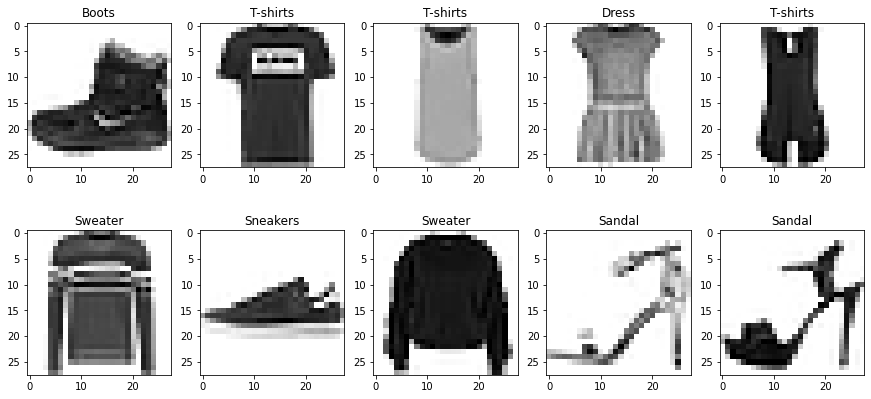

In [15]:
fig = plt.figure(figsize=(15, 7))

for i in range(10):
    plottable_image = np.reshape(x_train_all[i], (28, 28))
    ax = fig.add_subplot(2, 5, i+1)
    ax.title.set_text(class_names[y_train_all[i]])
    ax.imshow(plottable_image, cmap='gray_r')

In [16]:
from sklearn.model_selection import train_test_split 
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [17]:
print("학습 데이터셋 클래스별 샘플 수 : ", np.bincount(y_train))
print("평가 데이터셋 클래스별 샘플 수 : ", np.bincount(y_valid))

학습 데이터셋 클래스별 샘플 수 :  [4800 4800 4800 4800 4800 4800 4800 4800 4800 4800]
평가 데이터셋 클래스별 샘플 수 :  [1200 1200 1200 1200 1200 1200 1200 1200 1200 1200]


In [18]:
x_train = x_train / 255  # 0 ~ 1부터의 값으로 변환 
x_valid = x_valid / 255 
x_test = x_test / 255 

In [19]:
x_train_reshape = x_train.reshape(-1, 784)  # 28 x 28 -> 784 
x_valid_reshape = x_valid.reshape(-1, 784)
x_test_reshape = x_test.reshape(-1, 784)

print("학습 데이터 셋의 형태 : ", x_train_reshape.shape)
print("검증 데이터 셋의 형태 : ", x_valid_reshape.shape)

학습 데이터 셋의 형태 :  (48000, 784)
검증 데이터 셋의 형태 :  (12000, 784)


### 2. 원핫 인코딩하기

In [20]:
tf.keras.utils.to_categorical([0, 1, 3])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [21]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_valid_encoded = tf.keras.utils.to_categorical(y_valid)

In [22]:
print(y_train[0], y_train_encoded[0], class_names[y_train[0]])

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] Shirts


In [23]:
import torch
x_train_torch = torch.FloatTensor(x_train_reshape)
y_train_torch = torch.FloatTensor(y_train_encoded)
x_valid_torch = torch.FloatTensor(x_valid_reshape)
y_valid_torch = torch.FloatTensor(y_valid_encoded) 
x_test_torch = torch.FloatTensor(x_test_reshape)
y_test_torch = torch.FloatTensor(y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
  import sys


### 3. 신경망 만들기

In [24]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [25]:
class FashionDataset(Dataset):
  def __init__(self, x, y):
    '''
    x 100개를 데이터 다 불러와서 메모리에 올릴 수 있다.  
    x가 100개이고 메모리에는 10개를 올릴 수 밖에 없다면
    너무 무거워서 파일의 경로 100개를 적어줌
    '''
    self.x_data = x  
    self.y_data = y
  
  def __getitem__(self, index):
    x = self.x_data[index]  # 샘플을 하나를 선택 
    # x = np.load(x)  # x_data가 경로만 들어있다면 
    y = self.y_data[index]
    return x, y
  
  def collate_fn(self, batch):
    x, y = zip(*batch)  # batch size만큼 있음 
    return x, y

  def __len__(self):
    return len(self.x_data)

In [26]:
dataset = FashionDataset(x_train_torch, y_train_torch)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

In [27]:
for b in dataloader:
  x_batch = b[0]
  y_batch = b[1]
  print("배치 사이즈 : ", len(x_batch))
  print("데이터 크기 : ", x_batch.size())
  print("타겟 크기 : ", y_batch.size())
  break

배치 사이즈 :  32
데이터 크기 :  torch.Size([32, 784])
타겟 크기 :  torch.Size([32, 10])


In [28]:
from tqdm import tqdm 
import random 

random_seed = 123
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

model = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(), 
    nn.Linear(100, 10)
    )

optim = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

global_step = 0 
for epoch in range(10):  # epoch은 훈련 데이터셋을 한 번 다 보는 것을 epoch
  t = tqdm(dataloader, ncols=100)
  for i, batch in enumerate(t):
    x_batch = batch[0]
    y_batch = batch[1]
    output = model(x_batch)
    loss = criterion(output, y_batch)

    model.zero_grad() 
    optim.zero_grad()
    loss.backward()  # 그래디언트 (기울기) 구하고
    optim.step()  # 적용 (업데이트)

    global_step += 1
    t.set_description("epoch: {} | global_step: {:8d} | loss: {:.4f}".format(epoch + 1, global_step, loss))

  predicts = model(x_valid_torch)
  predicts = torch.argmax(predicts, 1)

  correct = 0 
  for i in range(len(predicts)):
    if predicts[i].item() == y_valid[i]:  # torch에서 scalar값 가져오기 위하여 item() 
      correct += 1
  acc = correct / len(predicts)
  print("epoch: {} | global_step: {} | valid acc: {:%}".format(epoch + 1, global_step, acc))

epoch: 1 | global_step:     1500 | loss: 0.6852: 100%|█████████| 1500/1500 [00:12<00:00, 119.11it/s]


epoch: 1 | global_step: 1500 | valid acc: 80.475000%


epoch: 2 | global_step:     3000 | loss: 0.4901: 100%|█████████| 1500/1500 [00:09<00:00, 163.54it/s]


epoch: 2 | global_step: 3000 | valid acc: 83.016667%


epoch: 3 | global_step:     4500 | loss: 0.6082: 100%|█████████| 1500/1500 [00:08<00:00, 171.18it/s]


epoch: 3 | global_step: 4500 | valid acc: 84.150000%


epoch: 4 | global_step:     6000 | loss: 0.7648: 100%|█████████| 1500/1500 [00:08<00:00, 172.15it/s]


epoch: 4 | global_step: 6000 | valid acc: 85.000000%


epoch: 5 | global_step:     7500 | loss: 0.5250: 100%|█████████| 1500/1500 [00:08<00:00, 171.25it/s]


epoch: 5 | global_step: 7500 | valid acc: 85.383333%


epoch: 6 | global_step:     9000 | loss: 0.5153: 100%|█████████| 1500/1500 [00:08<00:00, 170.58it/s]


epoch: 6 | global_step: 9000 | valid acc: 85.575000%


epoch: 7 | global_step:    10500 | loss: 0.6055: 100%|█████████| 1500/1500 [00:09<00:00, 163.16it/s]


epoch: 7 | global_step: 10500 | valid acc: 85.425000%


epoch: 8 | global_step:    12000 | loss: 0.3786: 100%|█████████| 1500/1500 [00:08<00:00, 171.26it/s]


epoch: 8 | global_step: 12000 | valid acc: 86.258333%


epoch: 9 | global_step:    13500 | loss: 0.5760: 100%|█████████| 1500/1500 [00:09<00:00, 155.53it/s]


epoch: 9 | global_step: 13500 | valid acc: 86.475000%


epoch: 10 | global_step:    15000 | loss: 0.2206: 100%|████████| 1500/1500 [00:08<00:00, 172.43it/s]


epoch: 10 | global_step: 15000 | valid acc: 86.616667%


In [29]:
predict = model(x_test_torch)
predict = torch.argmax(predict, 1)

In [30]:
correct = 0 
for i in range(len(predict)):
  if predict[i].item() == y_test[i]:
    correct += 1
acc = correct/len(predict)
print("Test accuracy : {:.2%}".format(acc))

Test accuracy : 84.91%


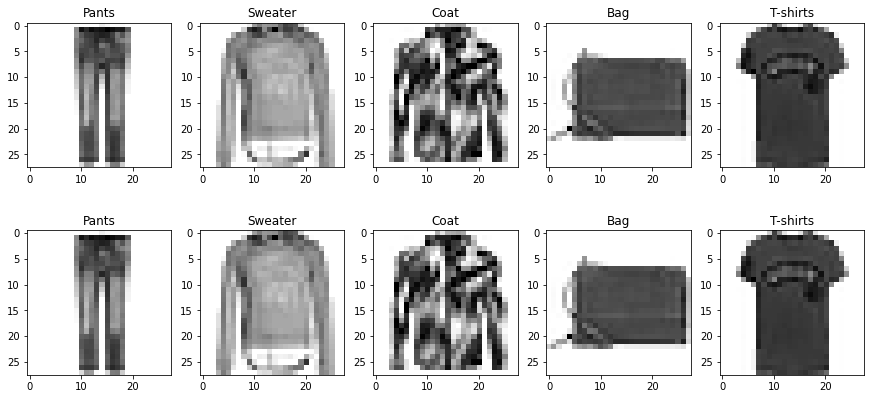

In [32]:
fig = plt.figure(figsize=(15, 7))

for i in range(5):
    plottable_image = x_test[i+15]
    ax = fig.add_subplot(2, 5, i+1)
    ax.title.set_text(class_names[y_test[i+15]])
    ax.imshow(plottable_image, cmap='gray_r')
  
for i in range(5):
    plottable_image = x_test[i+15]
    ax = fig.add_subplot(2, 5, i+6)
    ax.title.set_text(class_names[predict[i+15].item()])
    ax.imshow(plottable_image, cmap='gray_r')

plt.show()